In [40]:
from neuron import h, gui
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [63]:
cell = h.Section()
cell.insert('hh')
ic = h.IClamp(cell(0.5))

In [64]:
v = h.Vector().record(cell(0.5)._ref_v)
t = h.Vector().record(h._ref_t)
ina = h.Vector().record(cell(0.5)._ref_ina)
ik = h.Vector().record(cell(0.5)._ref_ik)

In [77]:
ic.amp = 8
ic.dur = 100
ic.delay = 50

In [78]:
h.tstop = 300

In [79]:
h.finitialize()
h.run()

0.0

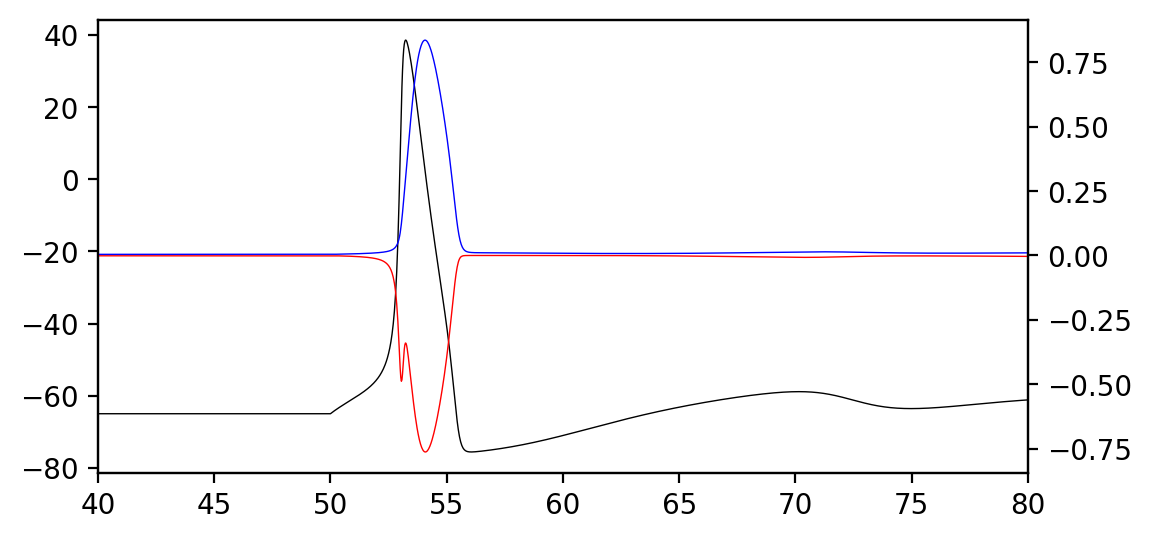

In [82]:
plt.figure(dpi=200, figsize=(6, 3))
plt.plot(t, v, 'k', lw=0.5)
plt.twinx()
plt.plot(t, ina, 'r', lw=0.5)
plt.plot(t, ik, 'b', lw=0.5)

plt.xlim([40, 80])
plt.show()

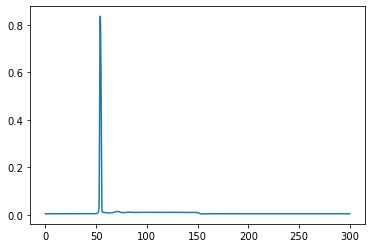

In [83]:
plt.plot(t, ik)

## LIF model

In [84]:
class LIFmodel:
    ####### description ########
    # cm*dv/dt = -g*(v - el) + I
    # -> tau*dv/dt = -(v - el) + R*I 
    # tau (ms), v (mV), t (ms), el (mV), R(mOhm), I (uV)
    #############################
    def __init__(self, tau=20, R=10, vth=-50, v0=-65, vmax=30, el=-65, vahp=-80, tahp=5, dt=0.01):
        # add constants
        self.tau = tau
        self.R = R
        self.v0 = v0
        self.vth = vth
        self.vmax = vmax
        self.el = el
        self.vahp = vahp
        self.dt = dt
        self.tahp = tahp
        self.tspk = -100
        self._init_obj()

    def _init_obj(self):
        self.v = self.v0
        self.flag_fire = False
        self.Iext = None
        self.n = 0 # count

    def update_all(self, Is, tmax):
        self.v = self.v0
        nitr = int(tmax / self.dt)
        self.ts = np.arange(0, tmax+self.dt/2, self.dt)
        self.vs = np.zeros(nitr+1)
        self.vs[0] = self.v
        for i in tqdm(range(nitr)):
            self.update(Is[i], self.ts[i])
            self.vs[i+1] = self.v

    def _f(self, v, I):
        return (-(v - self.el) + self.R*I) / self.tau

    def update(self, I, t):
        # use RK4 method
        if self.flag_fire:
            self.flag_fire = False
            self.v = self.vahp
        if t - self.tspk < self.tahp:
            I = 0
        dv1 = self._f(self.v, I)*self.dt
        dv2 = self._f(self.v+dv1/2, I)*self.dt
        dv3 = self._f(self.v+dv2/2, I)*self.dt
        dv4 = self._f(self.v+dv3, I)*self.dt
        # update
        self.v += 1/6*(dv1+dv2+dv3+dv4)
        if self.v > self.vth:
            # vnew = vmax
            self.v = self.vmax
            self.flag_fire = True
            self.tspk = t
    
    def add_current(self, ii):
        # ii, (n, ) list
        if self.Iext is None:
            self.Iext = ii
        else:
            self.Iext = np.vstack((self.Iext, ii))

    def reset(self):
        self._init_obj()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [00:02<00:00, 137172.35it/s]


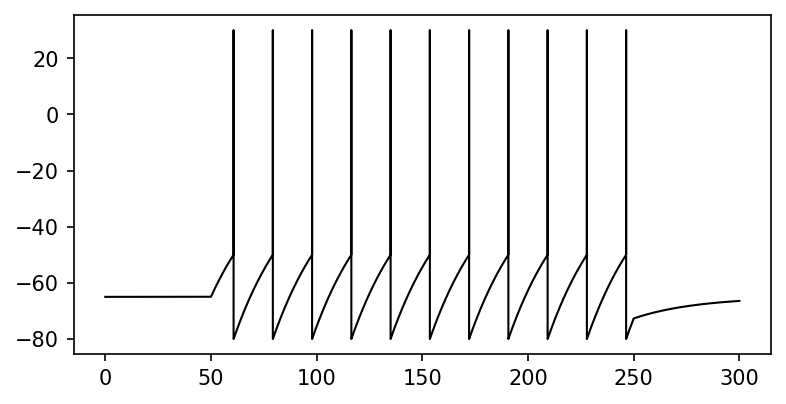

In [101]:
dt = 0.001
tmax = 300
Iext = np.zeros(int(tmax/dt))
ts = np.arange(0, tmax+dt/2, dt)
Iext[(ts[1:]>=50) & (ts[1:]<=250)] = 5

cell = LIFmodel(tau=20, R=10, vth=-50, v0=-65, vmax=30, el=-65, vahp=-80, tahp=0, dt=0.001)
cell.update_all(Iext, tmax)

plt.figure(dpi=150, figsize=(6, 3))
plt.plot(ts, cell.vs, 'k', lw=1)
# plt.xlim([50, 70])
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300000/300000 [00:01<00:00, 166762.05it/s]


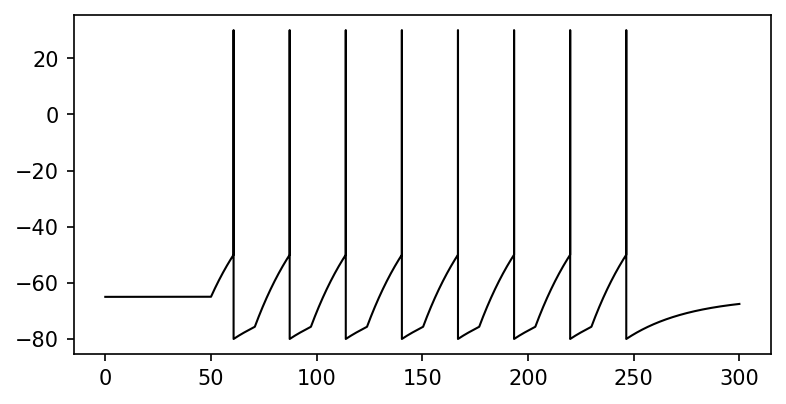

In [102]:
dt = 0.001
tmax = 300
Iext = np.zeros(int(tmax/dt))
ts = np.arange(0, tmax+dt/2, dt)
Iext[(ts[1:]>=50) & (ts[1:]<=250)] = 5

cell = LIFmodel(tau=20, R=10, vth=-50, v0=-65, vmax=30, el=-65, vahp=-80, tahp=10, dt=0.001)
cell.update_all(Iext, tmax)

plt.figure(dpi=150, figsize=(6, 3))
plt.plot(ts, cell.vs, 'k', lw=1)
# plt.xlim([50, 70])
plt.show()

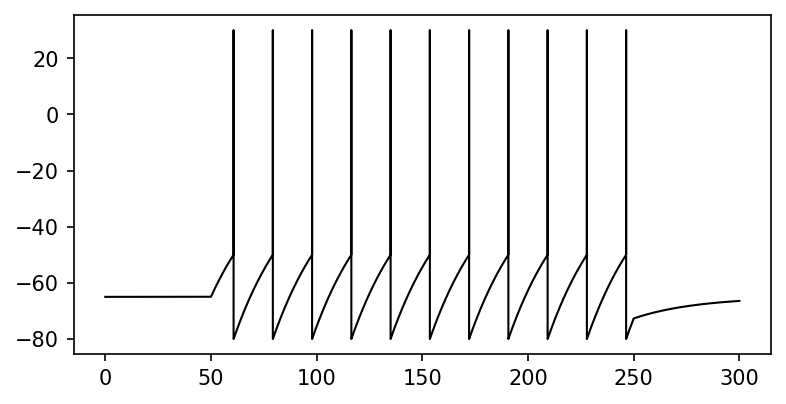